In [1]:
input_file = 'mh.out'

import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow_probability as tfp

import sys
sys.path.append('/Users/jay/Desktop/Bachelorarbeit/Implementation')
from dependencies.hbv_sask.model import HBVSASKModel as hbvmodel
from src.execute_model import run_model_single_parameter_node
from src.construct_model import get_model


ndims = 7
dims = ['TT', 'C0', 'beta', 'ETF', 'FC', 'FRAC', 'K2']
colors = sns.color_palette(n_colors=ndims)

configPath = "/Users/jay/Desktop/Bachelorarbeit/Implementation/configurations/config_short.json"
basis = "Oldman_Basin"
model = get_model(configPath, basis)

start_date: 2004-01-01 00:00:00
start_date_predictions: 2005-01-01 00:00:00
end_date: 2006-01-01 00:00:00
simulation length: 365
full_data_range is 732 hours including spin_up_length of 366 hours
simulation_range is of length 366 hours


In [2]:
# Construct params
configurationObject = model.configurationObject
param_lower = []
param_upper = []
for param in configurationObject["parameters"]:
    # for now the Uniform distribution is only supported
    if param["distribution"] == "Uniform":
        param_lower.append(param["lower"])
        param_upper.append(param["upper"])
    else:
        raise NotImplementedError(f"Sorry, the distribution {param['distribution']} is not supported yet")
param_lower = np.array(param_lower)
param_upper = np.array(param_upper)


def displot(i, data):
    # Plot sampled distribution
    fig = sns.displot(data, x=dims[i], kde=True, color=colors[i])

    # Plot distribution that is sampled from
    #uni = uniform(loc=param_lower[i], scale=param_upper[i] - param_lower[i])
    uni = tfp.distributions.Uniform(low=param_lower[i], high=param_upper[i])
    x = np.linspace(param_lower[i], param_upper[i], 25000)
    y = uni.prob(x)

    # Configuration
    plt.plot(x, y, label='pdf', color='grey')
    plt.title(f'PDF of parameter {dims[i]}')
    plt.show()
    fig.savefig(f'{dims[i]}_kde.png') 

def boxplot(i, data):
    sns.boxplot(data, x=dims[i], color=colors[i])
    plt.title(f'Boxplot of parameter {dims[i]}')
    plt.savefig(f'{dims[i]}_box.png')



In [3]:
samples = pd.read_csv(f'{input_file}')
samples

,TT,C0,beta,ETF,FC,FRAC,K2
0,1.268022,0.710443,1.452674,0.027719,167.438672,0.210824,0.039575
1,1.268022,0.710443,1.452674,0.027719,167.438672,0.210824,0.039575
2,1.268022,0.710443,1.452674,0.027719,167.438672,0.210824,0.039575
3,1.268022,0.710443,1.452674,0.027719,167.438672,0.210824,0.039575
4,1.268022,0.710443,1.452674,0.027719,167.438672,0.210824,0.039575
...,...,...,...,...,...,...,...
7996,1.434505,0.746294,1.617167,0.014074,67.314012,0.211784,0.045120
7997,1.434505,0.746294,1.617167,0.014074,67.314012,0.211784,0.045120
7998,1.434505,0.746294,1.617167,0.014074,67.314012,0.211784,0.045120
7999,1.434505,0.746294,1.617167,0.014074,67.314012,0.211784,0.045120


# Plotting

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight

2024-05-20 02:26:00.734605: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-05-20 02:26:00.734630: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-05-20 02:26:00.734634: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-05-20 02:26:00.734651: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-20 02:26:00.734662: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


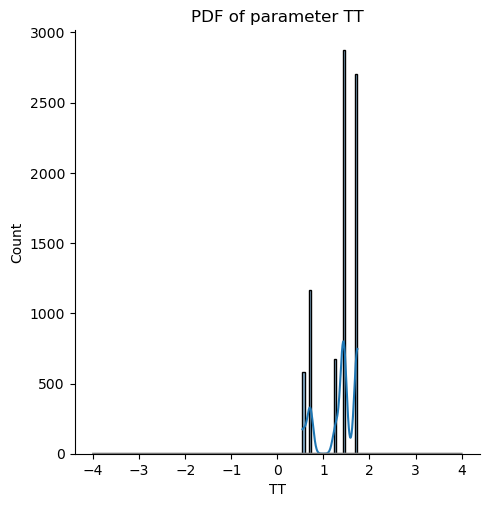

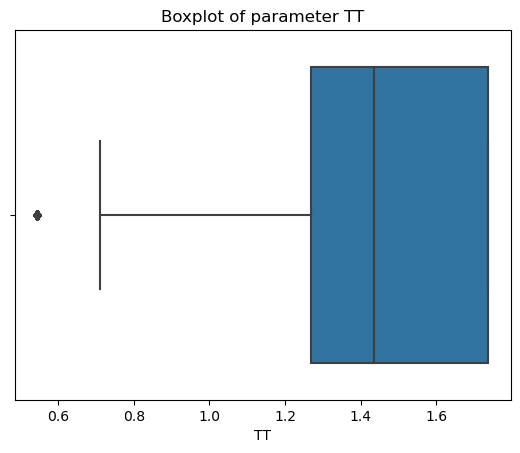

In [4]:
# Plot TT
displot(0, samples)
boxplot(0, samples)

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



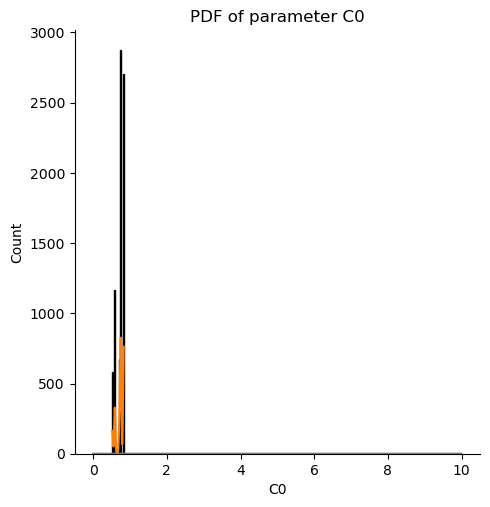

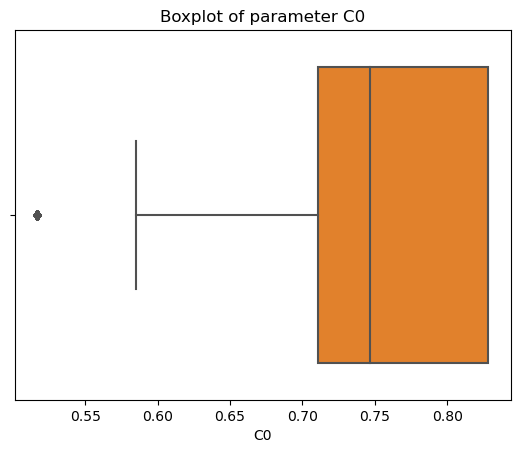

In [5]:
# Plot TT
displot(1, samples)
boxplot(1, samples)

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



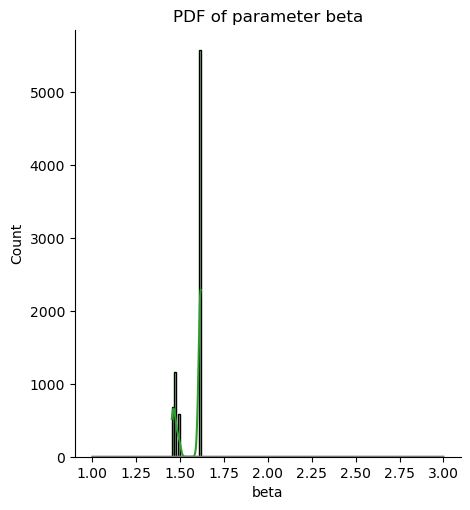

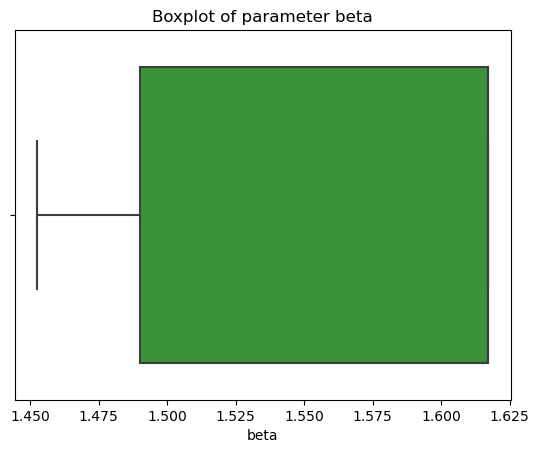

In [6]:
# Plot TT
displot(2, samples)
boxplot(2, samples)

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



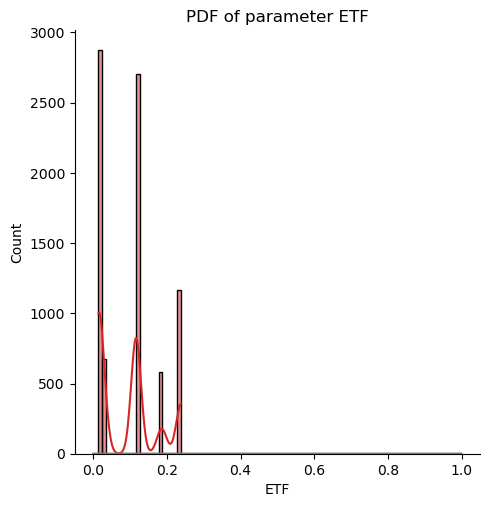

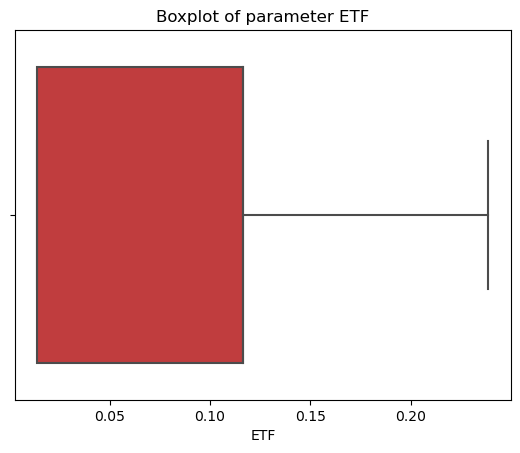

In [7]:
displot(3, samples)
boxplot(3, samples)

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



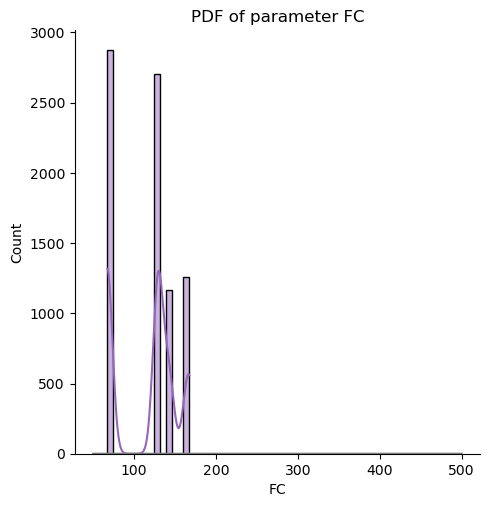

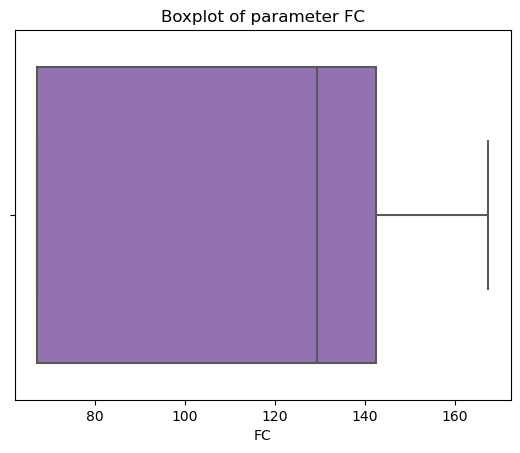

In [8]:
displot(4, samples)
boxplot(4, samples)

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



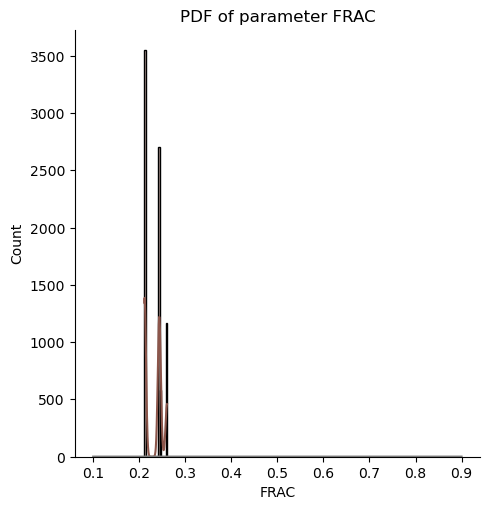

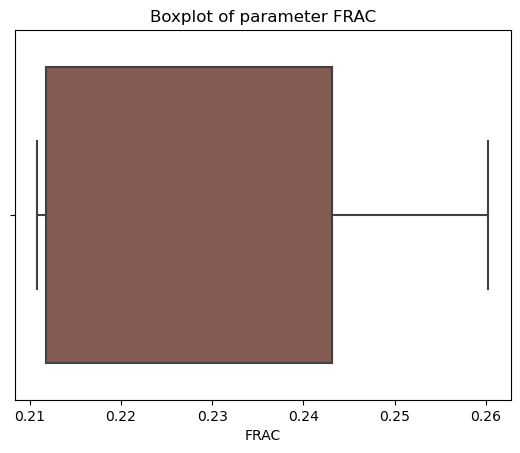

In [9]:
displot(5, samples)
boxplot(5, samples)

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



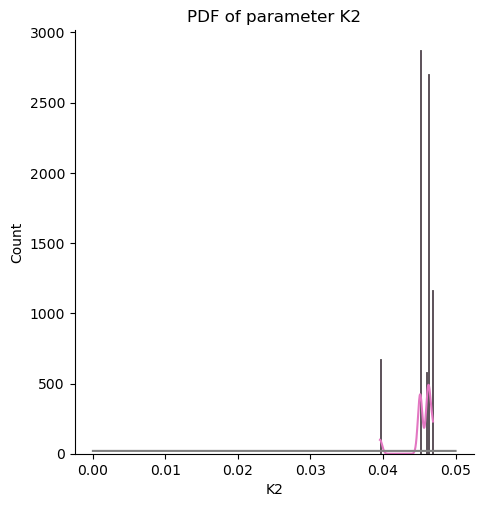

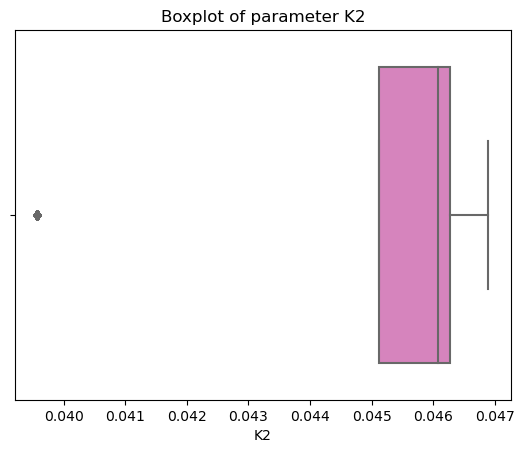

In [10]:
displot(6, samples)
boxplot(6, samples)

# Sampling

In [11]:
# Sampling Max
param_vec = []
for i in range(len(samples.loc[0])):
    values, counts = np.unique(samples.iloc[:, i], return_counts=True)
    ind = np.argmax(counts)
    param_vec.append(values[ind])

_, sampled_max, _, _ = run_model_single_parameter_node(model, param_vec)
    

[HVBSASK INFO] [0] parameters: [[1.434504875880367, 0.7462939497620966, 1.6171670281803388, 0.01407366083498618, 67.31401243866792, 0.21178356690523728, 0.045119986187204746]]


In [12]:
# Mean Sampling from MCMC
sample_param = []
for i in range(7):
    sample_param.append(np.random.choice(samples.iloc[:, i], 1000))
sample_param = np.array(sample_param).T

all_results = []
for _, vec in enumerate(sample_param):
    _, y_model, _, _ = run_model_single_parameter_node(model, np.array(vec))
    all_results.append(y_model)

print(np.array(all_results).shape)
sampled_column_means = np.mean(np.array(all_results), axis=0) 


[HVBSASK INFO] [0] parameters: [array([1.43450488e+00, 8.28351021e-01, 1.61713172e+00, 1.16471205e-01,
       1.67438672e+02, 2.11783567e-01, 4.51199862e-02])]
[HVBSASK INFO] [0] parameters: [array([1.73777211e+00, 8.28351021e-01, 1.61716703e+00, 1.40736608e-02,
       1.67438672e+02, 2.43106513e-01, 4.62743797e-02])]
[HVBSASK INFO] [0] parameters: [array([1.73777211e+00, 8.28351021e-01, 1.61716703e+00, 1.40736608e-02,
       6.73140124e+01, 2.43106513e-01, 4.62743797e-02])]
[HVBSASK INFO] [0] parameters: [array([5.45090290e-01, 8.28351021e-01, 1.46605279e+00, 2.38636649e-01,
       6.73140124e+01, 2.43106513e-01, 4.62743797e-02])]
[HVBSASK INFO] [0] parameters: [array([7.09760558e-01, 7.46293950e-01, 1.61713172e+00, 1.40736608e-02,
       6.73140124e+01, 2.60276299e-01, 4.51199862e-02])]
[HVBSASK INFO] [0] parameters: [array([1.73777211e+00, 7.46293950e-01, 1.45267384e+00, 1.40736608e-02,
       6.73140124e+01, 2.11783567e-01, 4.51199862e-02])]
[HVBSASK INFO] [0] parameters: [array([1

In [13]:
# Mean Sampling from Start
sample_param = []
for i in range(7):
    uni = tfp.distributions.Uniform(low=param_lower[i], high=param_upper[i]).sample(1)
    sample_param.append(uni)
sample_param = np.array(sample_param).T

all_results = []
for _, vec in enumerate(sample_param):
    _, y_model, _, _ = run_model_single_parameter_node(model, np.array(vec))
    all_results.append(y_model)

_, _, measured_data, _ = run_model_single_parameter_node(model, np.array(vec))

start_column_means = np.mean(np.array(all_results), axis=0)
    

[HVBSASK INFO] [0] parameters: [array([2.00334025e+00, 1.29028138e+00, 1.54935596e+00, 2.64232269e-01,
       3.66602523e+02, 4.35810790e-01, 8.46824207e-03])]
[HVBSASK INFO] [0] parameters: [array([2.00334025e+00, 1.29028138e+00, 1.54935596e+00, 2.64232269e-01,
       3.66602523e+02, 4.35810790e-01, 8.46824207e-03])]


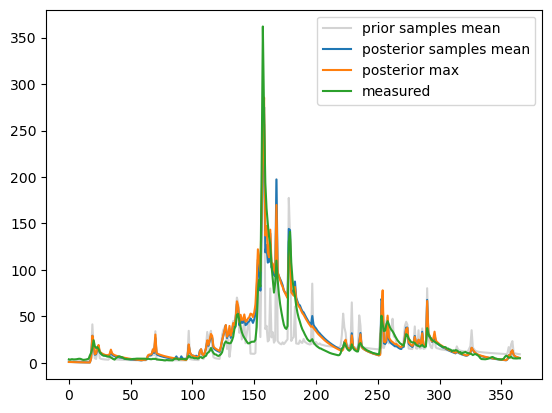

In [14]:
fig = plt.figure()
plt.plot(start_column_means, label='prior samples mean', color='lightgrey')
plt.plot(sampled_column_means, label='posterior samples mean')
plt.plot(sampled_max, label='posterior max')
plt.plot(measured_data, label='measured')
plt.legend()
plt.show()

In [15]:
t = (all_results - measured_data)[0]

s = 0
for i in range(len(t)):
    s += t[i] ** 2
rmse = (s / (len(t))) ** 0.5
rmse

22.841676221083198

In [16]:
t = sampled_max - measured_data

s = 0
for i in range(len(t)):
    s += t[i] ** 2
rmse = (s / (len(t))) ** 0.5
rmse

13.592720928905857

In [17]:
t = np.absolute(sampled_column_means - measured_data)

t.mean()

7.784229394569279

In [18]:
t = np.absolute(sampled_max - measured_data)

t.mean()

7.7012377652594655